In [32]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.datasets import ImageNet

import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import numpy as np

import os
import time
from utils import AddGaussianNoise, AddSaltPepperNoise
from timm.models import efficientnet_b0
from peff_b0 import PEffN_b0SeparateHP_V1

In [2]:
engram_dir = '/mnt/smb/locker/abbott-locker/hcnn_vision/'
data_root = '/mnt/smb/locker/abbott-locker/hcnn_vision/imagenet/'

# Clean images

In [3]:
clean_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [25]:
train_subset_indices = np.random.choice(8000, size=10, replace=False)
train_ds = ImageNet(data_root, split='val', transform=clean_transform)
train_subset = torch.utils.data.Subset(train_ds, train_subset_indices)

In [44]:
loader = torch.utils.data.DataLoader(train_subset, batch_size=1, drop_last=False)
load_iter = iter(loader)

In [51]:
feature, label = next(load_iter)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


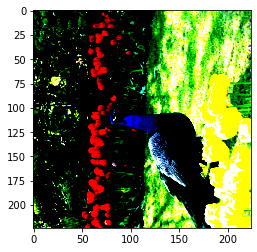

In [52]:
plt.figure()
plt.imshow(
    feature[0].transpose(0,2), interpolation='nearest'
    )
plt.show()

# Gaussian noise images

In [4]:
noise_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    AddGaussianNoise(std=1.50)
])

In [53]:
train_subset_indices = np.random.choice(8000, size=10, replace=False)
train_ds = ImageNet(data_root, split='val', transform=noise_transform)
train_subset = torch.utils.data.Subset(train_ds, train_subset_indices)

In [54]:
loader = torch.utils.data.DataLoader(train_subset, batch_size=1, drop_last=False)
load_iter = iter(loader)

In [57]:
feature, label = next(load_iter)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


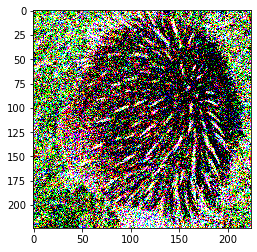

In [58]:
plt.figure()
plt.imshow(
    feature[0].transpose(0,2), interpolation='nearest'
    )
plt.show()